# Volume Quintile Analysis

This notebook analyzes the performance of assets grouped into 5 quintiles based on their rolling volume. We test the hypothesis that trading volume acts as a factor affecting cross-sectional returns.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Improt Strategy classes from local framework
from backtest_framework import (
    DataBundle, 
    MomentumIDParams, 
    MomentumIDStrategy, 
    LongShortVolWeighting, 
    compute_sharpe,
    compute_sortino_ratio,
    compute_calmar_ratio
)
from binance_data_loader import BinanceDataLoader

%matplotlib inline

## Load and Prepare Data
We load daily data and compute a 20-day rolling average of volume to smooth out noise for ranking purposes.

In [12]:
# Configure loader for daily data
data_loader = BinanceDataLoader(
    data_directory="/Users/chinjieheng/Documents/data/binance_dailydata",
    timeframe="1d",
    funding_rate_directory="/Users/chinjieheng/Documents/data/binance_fundingrate_data",
    min_records=60,
    min_volume=1e5,
    start_date="2022-09-01",
    end_date=None,
)

price = data_loader.get_price_matrix()

# 1. Volume & Rolling Volume
# Extract volume data via the loader's universe dictionary
volume_data = {t: data_loader._crypto_universe[t]['data']['volume'].reindex(price.index) for t in data_loader.get_universe()}
volume_df = pd.DataFrame(volume_data, index=price.index)

# 20-day rolling volume for robust quintile sorting
rolling_volume_df = volume_df.rolling(window=20, min_periods=10).mean()

# 2. BTC Filter (90d return)
btc_90d_return = price['BTCUSDT'].pct_change(90, fill_method=None) if 'BTCUSDT' in price.columns else None

# 3. Funding Rate Processing
funding_long = data_loader.get_funding_long_form()
funding_df = funding_long['fundingRate'].unstack(level=0).sort_index()
daily_funding = funding_df.resample('D').sum(min_count=1)

print(f"Price shape: {price.shape}")
print(f"Funding shape: {daily_funding.shape}")

Loading Binance data from /Users/chinjieheng/Documents/data/binance_dailydata (timeframe=1d)...
Found 611 USDT trading pairs
Using a 30-bar rolling window for 30d volume checks
✓ BTCUSDT loaded successfully with 1232 records, avg volume: 14,822,734,848
Loaded 590 cryptocurrencies
Filtered 18 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix (Memory Optimized)...
Matrix shape: (1232, 590)
Precomputed returns matrix shape: (1232, 590)
Date range: 2022-09-01 00:00:00 to 2026-01-14 00:00:00
Loading funding rate data from /Users/chinjieheng/Documents/data/binance_fundingrate_data...
Found 613 funding rate files
Loaded funding rates for 590 symbols
Price shape: (1232, 590)
Funding shape: (1232, 590)


## Initialize DataBundle
We use the `DataBundle` class to handle common data alignment and pre-computations (like forward returns).

In [13]:
# Initialize DataBundle
bundle = DataBundle(
    price_df=price,
    rolling_volume_df=rolling_volume_df,
    btc_ret=btc_90d_return,
    funding_df=daily_funding,
    min_hist_days=30
)

# MATCH CONFIG: Using exact windows from walkforward_class_1d.ipynb
simple_windows = [7, 12, 14]
vol_windows = [15, 20, 25, 30, 35, 40, 45]

# Ensure bundles have these computed
bundle.ensure_simple_returns(simple_windows)
bundle.ensure_id_matrix(simple_windows)
bundle.ensure_vol_matrix(vol_windows)

print("Bundle initialized and matrices precomputed (Aligned with walkforward_class_1d).")

Bundle initialized and matrices precomputed (Aligned with walkforward_class_1d).


## Execute Quintile Backtest Loop
We iterate through each day, sort the universe by volume, split into 5 buckets (Low to High), and calculate the equal-weighted return for each bucket for the next day.

In [14]:
from itertools import product
from backtest_framework import WalkForwardRunner

# 1. Define Custom Weighting that enforces Quintile logic
# KEY FIX: Mimic the original _universe_mask logic exactly:
#   - Rank ALL assets with finite volume FIRST
#   - Select quintile
#   - THEN intersect with validity mask
class QuintileWeighting(LongShortVolWeighting):
    def __init__(self, target_quintile: int, n_quintiles: int = 5):
        self.target_quintile = target_quintile
        self.n_quintiles = n_quintiles
        
    def weights(self, idx, signals, bundle, universe_mask, params):
        vol_row = bundle.rolling_volume_np[idx]
        
        # STEP 1: Get ALL assets with finite volume (before any other filtering)
        # This matches the original logic in _universe_mask
        all_finite_vol_idx = np.where(np.isfinite(vol_row))[0]
        n_total = len(all_finite_vol_idx)
        
        if n_total < self.n_quintiles:
            return np.zeros(len(vol_row))
        
        # STEP 2: Sort by volume and split into quintiles
        # Sort Low -> High, so Q5 (index 4) = highest volume
        sorted_args = np.argsort(vol_row[all_finite_vol_idx])
        sorted_indices = all_finite_vol_idx[sorted_args]
        
        # np.array_split distributes remainder to first chunks
        # Last chunk (Q5) has size floor(N/5), matching int(N*0.2) truncation
        chunks = np.array_split(sorted_indices, self.n_quintiles)
        quintile_indices = chunks[self.target_quintile]
        
        # STEP 3: NOW intersect with the validity mask (base filters)
        # This is equivalent to: mask[top_idx] = True; mask &= base
        quintile_mask = np.zeros(len(vol_row), dtype=bool)
        quintile_mask[quintile_indices] = True
        final_mask = quintile_mask & universe_mask
        
        # Pass to parent weighting logic with the final filtered mask
        return super().weights(idx, signals, bundle, final_mask, params)

# 2. Define Parameter Grid (MATCHING walkforward_class_1d.ipynb)
grid_choices = {
    "simple_window": simple_windows,    # [7, 12, 14]
    "vol_window": vol_windows,          # [15, 20, 25, 30, 35, 40, 45]
    "momentum_pct": [0.1],              # Matching original 0.1
    "max_positions_per_side": [10],     # Matching original 10
    
    # Standard Constants
    "weighting_method": ["vol"],
    "max_position_cap": [0.3],
    "tc_bps": [5],
    "use_btc_filter": [True]
}

param_grid = []
for sw in grid_choices["simple_window"]:
    for vw in grid_choices["vol_window"]:
        for mp in grid_choices["momentum_pct"]:
             param_grid.append(
                MomentumIDParams(
                    simple_window=sw,
                    id_window=sw, 
                    vol_window=vw,
                    
                    # QUINTILE ADAPTATION:
                    # Volume filtering is handled by QuintileWeighting.
                    # We set volume_pct=1.0 so BacktestEngine passes the full valid universe.
                    volume_pct=1.0, 
                    
                    momentum_pct=mp,
                    momentum_mode="relative",
                    weighting_method="vol",
                    long_id_threshold=-0.8,
                    short_id_threshold=-0.8,
                    max_positions_per_side=10, 
                    max_position_cap=0.3,
                    min_weight=0.05,
                    tc_bps=5,
                    use_btc_filter=True
                )
            )

print(f"Grid size: {len(param_grid)} combinations.")

# 3. Strategy Factory
def make_strategy(params):
    return MomentumIDStrategy(params)

# 4. Multi-Quintile Walk-Forward Loop
quintile_names = ['Q1 (Low Vol)', 'Q2', 'Q3', 'Q4', 'Q5 (High Vol)']
quintile_results = {}

print("Starting Walk-Forward Optimization per Quintile...")
# MATCH CONFIG: 365 days training span
train_span = 365  
test_span = 90
step_span = 90

for q in range(5):
    print(f"\n=== Optimizing {quintile_names[q]} ===")
    
    # Custom weighting for this quintile
    weighting_model = QuintileWeighting(target_quintile=q)
    
    runner = WalkForwardRunner(
        periods_per_year=365,
        bundle=bundle,
        strategy_factory=make_strategy,
        weighting_model=weighting_model,
        params_grid=param_grid,
        train_span=train_span,
        test_span=test_span,   
        step_span=step_span,
        mode="expanding",
        score_mode="composite",
        n_jobs=-1 
    )
    
    # Run Optimization
    wf_df, oos_returns, oos_equity, positions_df = runner.run()
    
    sharpe = compute_sharpe(oos_returns, periods_per_year=365)
    total_ret = (1 + oos_returns).prod() - 1
    
    print(f"-> OOS Sharpe: {sharpe:.2f}")
    
    quintile_results[quintile_names[q]] = {
        'wf_df': wf_df,
        'oos_returns': oos_returns,
        'oos_equity': oos_equity,
        'sharpe': sharpe
    }

print("\nAll Quintiles Processed.")

Grid size: 21 combinations.
Starting Walk-Forward Optimization per Quintile...

=== Optimizing Q1 (Low Vol) ===
-> OOS Sharpe: -0.14

=== Optimizing Q2 ===
-> OOS Sharpe: -0.63

=== Optimizing Q3 ===
-> OOS Sharpe: 0.21

=== Optimizing Q4 ===
-> OOS Sharpe: 0.85

=== Optimizing Q5 (High Vol) ===
-> OOS Sharpe: 2.10

All Quintiles Processed.


## Analyze and Visualize Results
We plot cumulative equity curves and compute performance metrics (Sharpe, Total Return) for each quintile.

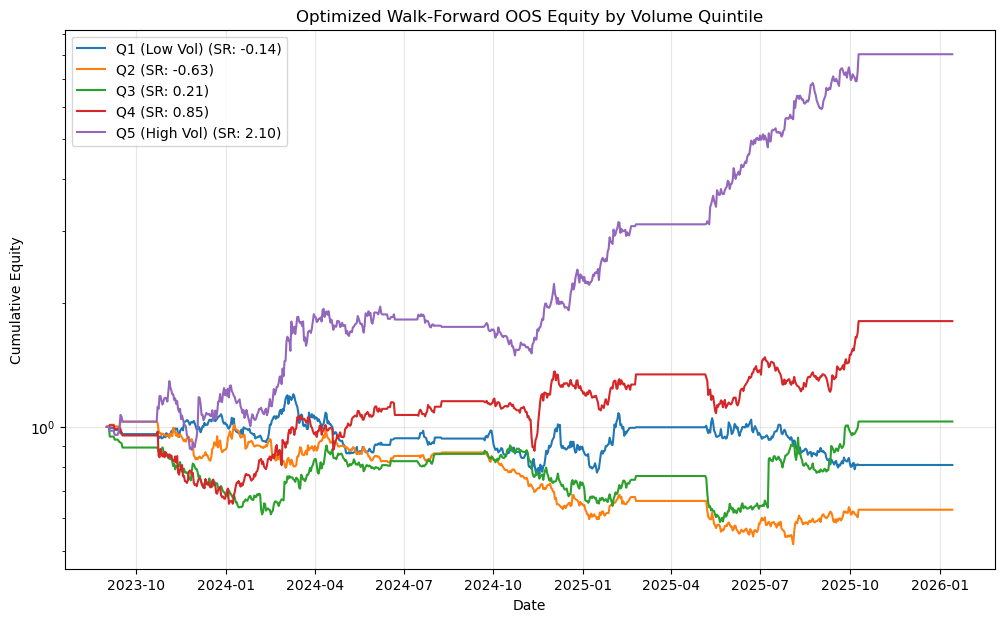

,Sharpe (365d),Sortino,Calmar,Total Return,Max DD
Quintile,,,,,
Q1 (Low Vol),-0.138436,-0.161893,-0.117102,-0.192048,-0.363175
Q2,-0.630559,-0.766823,-0.324132,-0.370937,-0.500050
Q3,0.209140,0.320036,0.188030,0.030496,-0.412899
Q4,0.847099,0.961782,0.902753,0.807267,-0.355654
Q5 (High Vol),2.102302,3.444869,3.088824,7.046523,-0.319219


In [15]:
# 5. Visualize Optimized OOS Performance

plt.figure(figsize=(12, 7))

final_stats = []

for name, res in quintile_results.items():
    equity = res['oos_equity']
    returns = res['oos_returns']
    
    # Re-verify Sharpe Calculation (Annualized 365)
    # Using local compute_sharpe, ensure it uses 365
    sharpe = compute_sharpe(returns, periods_per_year=365)
    try:
        sortino = compute_sortino_ratio(returns, periods_per_year=365)
    except:
        sortino = np.nan
    
    try:
        calmar = compute_calmar_ratio(returns, periods_per_year=365)
    except:
        calmar = np.nan
        
    plt.plot(equity.index, equity.values, label=f"{name} (SR: {sharpe:.2f})")
    
    final_stats.append({
        'Quintile': name,
        'Sharpe (365d)': sharpe,
        'Sortino': sortino,
        'Calmar': calmar,
        'Total Return': (1+returns).prod() - 1,
        'Max DD': equity.div(equity.cummax()).min() - 1
    })

plt.title('Optimized Walk-Forward OOS Equity by Volume Quintile')
plt.xlabel('Date')
plt.ylabel('Cumulative Equity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

pd.DataFrame(final_stats).set_index('Quintile')